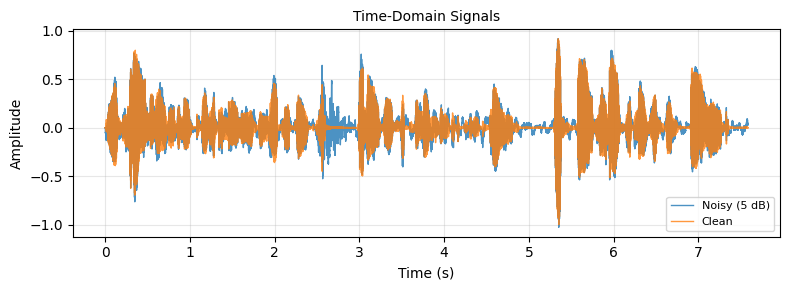

In [1]:
from core.audio_io import load_audio, play_audio, save_audio, normalize
from core.mixing import mix_with_snr
from core.visualization import plot_waveforms, plot_spectrogram

clean, fs = load_audio("data/clean/clean_speech.wav")
noise, _ = load_audio("data/noise/office.wav")

noisy, _ = mix_with_snr(clean, noise, snr_db=5)

plot_waveforms(
    [noisy, clean],
    ["Noisy (5 dB)", "Clean"],
    fs,
    "Time-Domain Signals"
)

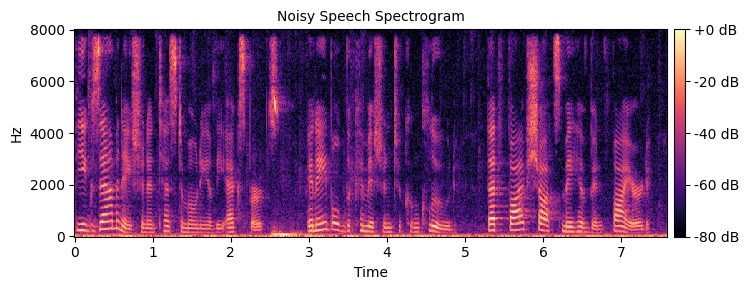

In [2]:
plot_spectrogram(noisy, fs, "Noisy Speech Spectrogram")

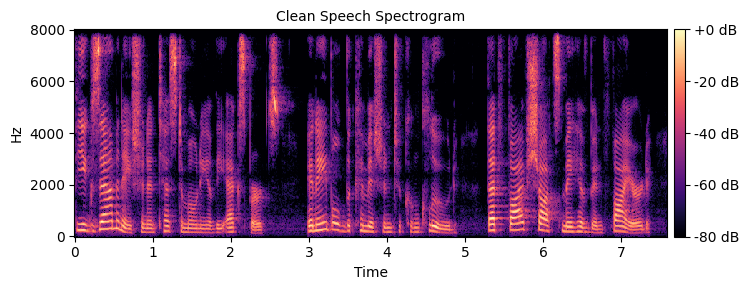

In [3]:
plot_spectrogram(clean, fs, "Clean Speech Spectrogram")

In [4]:
# mix the clean and noise at 5 dB SNR and play the noisy signal
from analysis.noise_classifier import classify_noise

clean, fs = load_audio("data/clean/clean_speech.wav")
noise, _ = load_audio("data/noise/white.wav")
noise = normalize(noise)

noisy, _ = mix_with_snr(clean, noise, snr_db=10)

play_audio(noisy, fs)


In [5]:
from core.audio_io import load_audio
from core.mixing import mix_with_snr
from analysis.noise_classifier import classify_noise
from analysis.noise_classifier import classify_noise_DEBUG

clean, fs = load_audio("data/clean/clean_speech.wav")
noise, _ = load_audio("data/noise/office.wav")
noise = normalize(noise)
clean = normalize(clean)
noisy, _ = mix_with_snr(clean, noise, snr_db=0)

noise_type = classify_noise(noisy, fs)
print("Detected noise type:", noise_type)



Detected noise type: highly_nonstationary


In [6]:
from core.audio_io import load_audio, normalize, play_audio
from core.mixing import mix_with_snr
from enhancement.spectral_subtraction import spectral_subtraction
from evaluation.benchmarking import evaluate_method, print_results

clean, fs = load_audio("data/clean/clean_speech.wav")
noise, _ = load_audio("data/noise/white.wav")
noise = normalize(noise)
clean = normalize(clean)
noisy, _ = mix_with_snr(clean, noise, snr_db=5)

x_ss = spectral_subtraction(noisy, fs)

print("Noisy")
play_audio(normalize(noisy), fs)


Noisy


In [7]:
res_ss = evaluate_method(clean, noisy, x_ss)
print("Spectral Subtraction")
print_results(res_ss)
play_audio(normalize(x_ss), fs)

Spectral Subtraction
SNR_in (dB)           : 5.000
SNR_out (dB)          : 9.015
SNR_improvement (dB)  : 4.015
Segmental_SNR (dB)    : 2.396
MSE                   : 0.001
LSD                   : 18.447


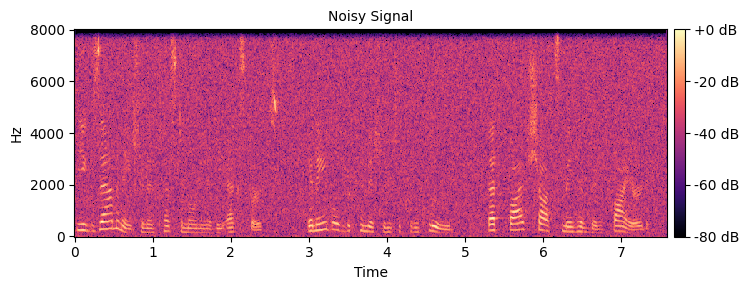

In [8]:
plot_spectrogram(noisy, fs, "Noisy Signal")


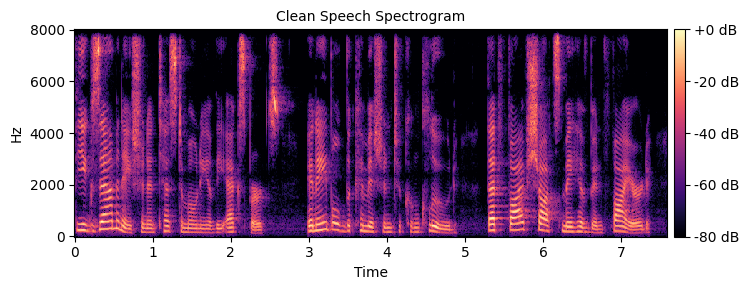

In [9]:
plot_spectrogram(clean, fs, "Clean Speech Spectrogram")

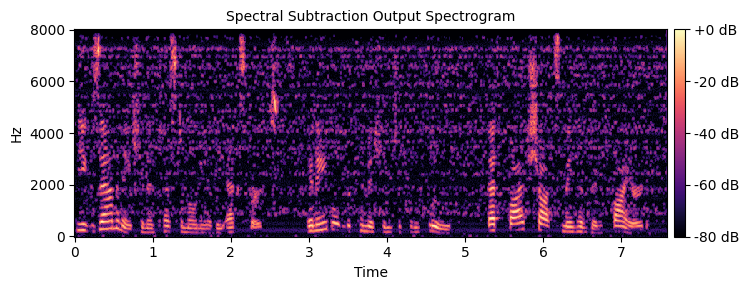

In [10]:
plot_spectrogram(x_ss, fs, "Spectral Subtraction Output Spectrogram")


In [11]:
from enhancement.wiener_static import wiener_filter_static

clean, fs = load_audio("data/clean/clean_speech.wav")
noise, _ = load_audio("data/noise/white.wav")
noise = normalize(noise)
clean = normalize(clean)
noisy, _ = mix_with_snr(clean, noise, snr_db=5)

x_wiener = wiener_filter_static(noisy, fs)

print("Noisy")
play_audio(normalize(noisy), fs)


Noisy


In [12]:
res_wiener = evaluate_method(clean, noisy, x_wiener)
print("Wiener Static")
print_results(res_wiener)
play_audio(normalize(x_wiener), fs)

Wiener Static
SNR_in (dB)           : 5.000
SNR_out (dB)          : 10.578
SNR_improvement (dB)  : 5.578
Segmental_SNR (dB)    : 4.570
MSE                   : 7.96e-04
LSD                   : 17.121


In [13]:
play_audio(normalize(x_ss), fs)

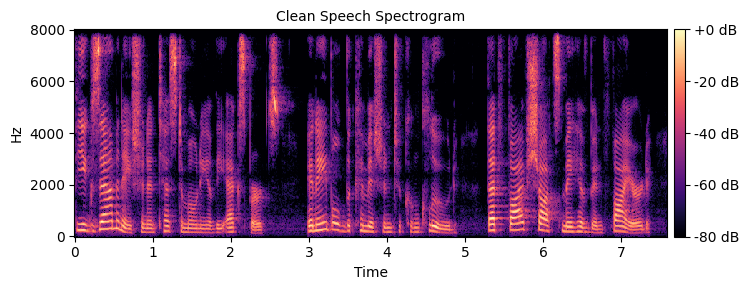

In [14]:
plot_spectrogram(clean, fs, "Clean Speech Spectrogram")

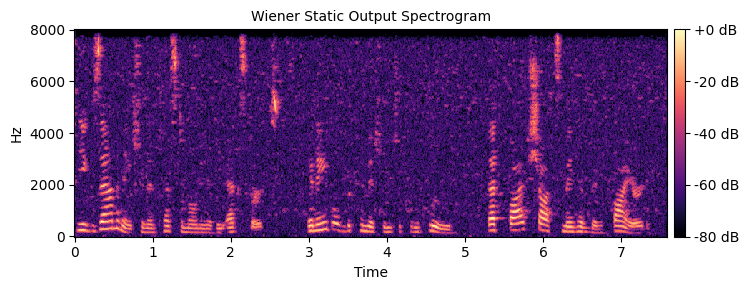

In [15]:
plot_spectrogram(x_wiener, fs, "Wiener Static Output Spectrogram")

In [29]:
from enhancement.wiener_static import wiener_filter_static
from enhancement.spectral_subtraction import spectral_subtraction

noisy_efe, fs = load_audio("data/real_recordings/ac_noise.wav")
x_efe = wiener_filter_static(noisy_efe, fs)

print("Noisy")
play_audio(noisy_efe, fs)


Noisy


In [30]:
play_audio(x_efe, fs)

In [17]:
play_audio(x_efe, fs)

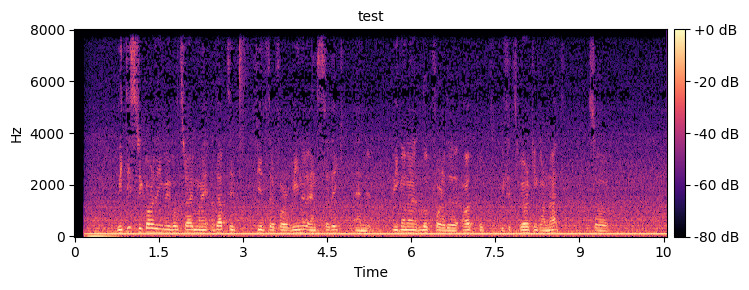

In [18]:
plot_spectrogram(noisy_efe, fs, "test")


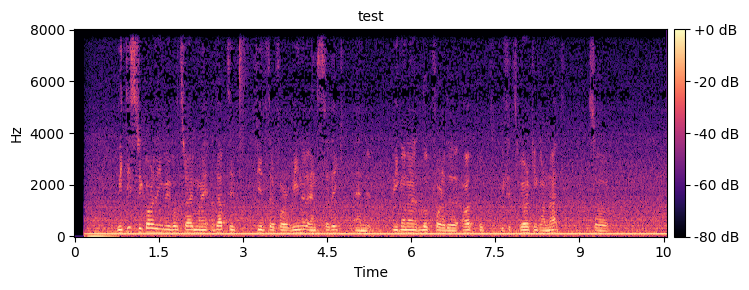

In [19]:
plot_spectrogram(x_efe, fs, "test")

In [32]:
s1_raw, fs = load_audio("data/real_recordings/ica_s1.wav")
s2_raw, fs = load_audio("data/real_recordings/ica_s2.wav")

play_audio(s2_raw, fs)

In [ ]:


import numpy as np
from core.audio_io import load_audio, normalize

def align_recordings_by_clap(file_path1, file_path2, search_window_sec=5.0):
    """
    Loads two audio files and aligns them based on the loudest peak (clap)
    occurring within the first few seconds.
    """
    # 1. Load Audio
    # We load standard mono; if stereo, we take the first channel.
    s1, fs1 = load_audio(file_path1)
    s2, fs2 = load_audio(file_path2)
    
    if fs1 != fs2:
        raise ValueError(f"Sample rates do not match! {fs1} vs {fs2}")
    
    fs = fs1
    
    # 2. Define Search Region (First 5 seconds only)
    # This prevents aligning to a loud cough or shout later in the recording.
    search_limit = int(search_window_sec * fs)
    
    region1 = np.abs(s1[:search_limit])
    region2 = np.abs(s2[:search_limit])
    
    # 3. Find the Clap (Index of Maximum Amplitude)
    clap_idx1 = np.argmax(region1)
    clap_idx2 = np.argmax(region2)
    
    print(f"Clap detected in File 1 at: {clap_idx1 / fs:.3f} sec")
    print(f"Clap detected in File 2 at: {clap_idx2 / fs:.3f} sec")
    
    # 4. Trim signals
    # We cut everything before the clap so both start exactly at the impulse.
    s1_aligned = s1[clap_idx1:]
    s2_aligned = s2[clap_idx2:]
    
    # 5. Match Lengths
    # Truncate the longer signal so they are exactly the same length for ICA
    min_len = min(len(s1_aligned), len(s2_aligned))
    s1_aligned = s1_aligned[:min_len]
    s2_aligned = s2_aligned[:min_len]
    
    return s1_aligned, s2_aligned, fs

s1, s2, fs = align_recordings_by_clap("data/real_recordings/ica_s1.wav", "data/real_recordings/ica_s2.wav", search_window_sec=5.0)
play_audio(s2, fs)

Clap detected in File 1 at: 1.609 sec
Clap detected in File 2 at: 1.578 sec


In [ ]:
L1 = len(s1)
N = int(L1/3)
s1_cl = s1[N:]
s2_cl = s2[N:]
play_audio(s2_cl, fs)

In [48]:
from core.audio_io import save_audio
save_audio("data/real_recordings/ica_s1_sync.wav", s1_cl, fs)
save_audio("data/real_recordings/ica_s2_sync.wav", s2_cl, fs)